In [ ]:
# Importing Libraries

In [1]:
import pandas as pd
import numpy as np

In [2]:

import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

In [3]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [4]:
# Data directory
import os
print (os.listdir("../input/uci_har_dataset/UCI_HAR_Dataset"))

['test', 'README.txt', '_DS_Store', 'csv_files', 'features.txt', 'features_info.txt', 'activity_labels.txt', 'train']


In [5]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [6]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'../input/uci_har_dataset/UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [7]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'../input/uci_har_dataset/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [8]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [10]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [11]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [12]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [13]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [14]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [15]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [16]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [17]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


- Defining the Architecture of LSTM

In [18]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [20]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 85s 12ms/step - loss: 1.3296 - acc: 0.4358 - val_loss: 1.1595 - val_acc: 0.4737
Epoch 2/30
7352/7352 [==============================] - 82s 11ms/step - loss: 1.0021 - acc: 0.5626 - val_loss: 0.9326 - val_acc: 0.5667
Epoch 3/30
7352/7352 [==============================] - 81s 11ms/step - loss: 0.8065 - acc: 0.6518 - val_loss: 0.7835 - val_acc: 0.6111
Epoch 4/30
7352/7352 [==============================] - 80s 11ms/step - loss: 0.6917 - acc: 0.6680 - val_loss: 0.7751 - val_acc: 0.6135
Epoch 5/30
7352/7352 [==============================] - 82s 11ms/step - loss: 0.6580 - acc: 0.6795 - val_loss: 0.7688 - val_acc: 0.6050
Epoch 6/30
7352/7352 [==============================] - 80s 11ms/step - loss: 0.5934 - acc: 0.6942 - val_loss: 0.8312 - val_acc: 0.6237
Epoch 7/30
7352/7352 [==============================] - 80s 11ms/step - loss: 0.5726 - acc: 0.7165 - val_loss: 0.6860 - val_acc: 0.7197


In [21]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING        ...         WALKING_UPSTAIRS
True                              ...                         
LAYING                 508        ...                        0
SITTING                  0        ...                        3
STANDING                 0        ...                        0
WALKING                  0        ...                       22
WALKING_DOWNSTAIRS       0        ...                       22
WALKING_UPSTAIRS         0        ...                      433

[6 rows x 6 columns]


In [22]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 6s 2ms/step


In [23]:
score

[0.4742050037249046, 0.9009161859518154]

Test score: 0.4742050037249046
Test accuracy: 0.9009161859518154


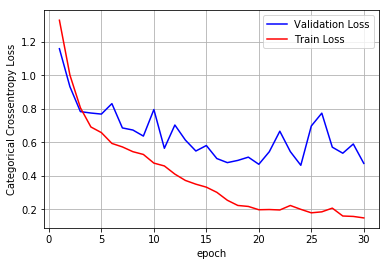

In [24]:
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

nb_epoch = 30
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs


vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

- With a simple 2 layer architecture we got 89.31% accuracy and a loss of 0.53
- We can further imporve the performace with Hyperparameter tuning

In [25]:
# experiment 1 - increase n_hidden layers to see if we can incerase the accuracy of the model

In [26]:
n_hidden = 64
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [28]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 86s 12ms/step - loss: 1.2618 - acc: 0.4338 - val_loss: 1.3960 - val_acc: 0.3451
Epoch 2/30
7352/7352 [==============================] - 83s 11ms/step - loss: 1.0835 - acc: 0.5195 - val_loss: 1.0707 - val_acc: 0.5310
Epoch 3/30
7352/7352 [==============================] - 83s 11ms/step - loss: 0.9083 - acc: 0.5846 - val_loss: 0.8354 - val_acc: 0.6274
Epoch 4/30
7352/7352 [==============================] - 83s 11ms/step - loss: 0.7491 - acc: 0.6623 - val_loss: 0.7822 - val_acc: 0.6464
Epoch 5/30
7352/7352 [==============================] - 84s 11ms/step - loss: 0.6142 - acc: 0.7534 - val_loss: 0.6764 - val_acc: 0.7601
Epoch 6/30
7352/7352 [==============================] - 83s 11ms/step - loss: 0.4264 - acc: 0.8575 - val_loss: 0.4614 - val_acc: 0.8537
Epoch 7/30
7352/7352 [==============================] - 83s 11ms/step - loss: 0.3264 - acc: 0.8947 - val_loss: 0.4077 - val_acc: 0.8795


In [29]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING        ...         WALKING_UPSTAIRS
True                              ...                         
LAYING                 537        ...                        0
SITTING                  0        ...                        3
STANDING                 0        ...                        0
WALKING                  0        ...                       33
WALKING_DOWNSTAIRS       0        ...                        1
WALKING_UPSTAIRS         0        ...                      457

[6 rows x 6 columns]


In [30]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 6s 2ms/step


In [31]:
score

[0.42448869158405805, 0.9158466236851035]

Test score: 0.42448869158405805
Test accuracy: 0.9158466236851035


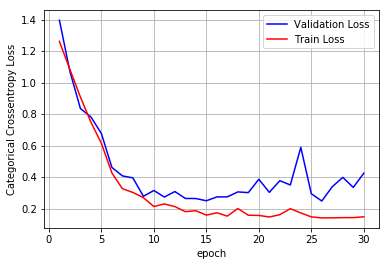

In [32]:
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

nb_epoch = 30
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs


vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

- With 64 nodes we got 91.27% accuracy and a loss of 0.40 on test set, as we can see it increased almost 2% in test accuracy.

In [33]:
# experiment 2 -now keeping the n_hidden = 32 we increase the dropout rate to see if we observe 
# its effect on accuracy

In [34]:
n_hidden = 32
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.8))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [35]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [36]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 85s 12ms/step - loss: 1.5132 - acc: 0.3383 - val_loss: 1.3459 - val_acc: 0.3695
Epoch 2/30
7352/7352 [==============================] - 84s 11ms/step - loss: 1.2444 - acc: 0.4610 - val_loss: 1.1792 - val_acc: 0.4652
Epoch 3/30
7352/7352 [==============================] - 83s 11ms/step - loss: 1.1636 - acc: 0.4819 - val_loss: 1.0971 - val_acc: 0.4791
Epoch 4/30
7352/7352 [==============================] - 84s 11ms/step - loss: 1.0942 - acc: 0.4993 - val_loss: 1.0629 - val_acc: 0.5310
Epoch 5/30
7352/7352 [==============================] - 85s 12ms/step - loss: 1.0531 - acc: 0.5156 - val_loss: 1.0525 - val_acc: 0.5199
Epoch 6/30
7352/7352 [==============================] - 83s 11ms/step - loss: 1.0005 - acc: 0.5456 - val_loss: 0.9198 - val_acc: 0.5579
Epoch 7/30
7352/7352 [==============================] - 84s 11ms/step - loss: 1.0164 - acc: 0.5462 - val_loss: 0.9133 - val_acc: 0.5789


In [37]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING        ...         WALKING_UPSTAIRS
True                              ...                         
LAYING                 517        ...                        0
SITTING                  2        ...                        0
STANDING                 0        ...                        0
WALKING                  0        ...                        0
WALKING_DOWNSTAIRS       1        ...                        0
WALKING_UPSTAIRS         0        ...                        3

[6 rows x 6 columns]


In [38]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 6s 2ms/step


In [39]:
score

[0.5252776635089567, 0.7461825585341024]

Test score: 0.5252776635089567
Test accuracy: 0.7461825585341024


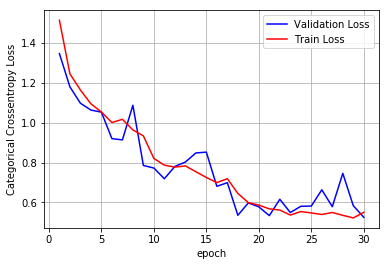

In [40]:
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

nb_epoch = 30
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs


vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

- We can see as we increased the dropout rate to 0.8 the accuracy of the model decreased to 67.69%  and loss increase to 0.73

In [41]:
n_hidden = 32
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.3))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [42]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [43]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 82s 11ms/step - loss: 1.2564 - acc: 0.4678 - val_loss: 1.0668 - val_acc: 0.5602
Epoch 2/30
7352/7352 [==============================] - 81s 11ms/step - loss: 0.9296 - acc: 0.5918 - val_loss: 0.8612 - val_acc: 0.6135
Epoch 3/30
7352/7352 [==============================] - 81s 11ms/step - loss: 0.7798 - acc: 0.6372 - val_loss: 0.7487 - val_acc: 0.6352
Epoch 4/30
7352/7352 [==============================] - 83s 11ms/step - loss: 0.6894 - acc: 0.6725 - val_loss: 0.7777 - val_acc: 0.6247
Epoch 5/30
7352/7352 [==============================] - 81s 11ms/step - loss: 0.6221 - acc: 0.7243 - val_loss: 0.6411 - val_acc: 0.7424
Epoch 6/30
7352/7352 [==============================] - 81s 11ms/step - loss: 0.5446 - acc: 0.7946 - val_loss: 0.5400 - val_acc: 0.7896
Epoch 7/30
7352/7352 [==============================] - 81s 11ms/step - loss: 0.4518 - acc: 0.8536 - val_loss: 0.4766 - val_acc: 0.8358


In [44]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING        ...         WALKING_UPSTAIRS
True                              ...                         
LAYING                 527        ...                        0
SITTING                  0        ...                        1
STANDING                 0        ...                        0
WALKING                  0        ...                       12
WALKING_DOWNSTAIRS       0        ...                       30
WALKING_UPSTAIRS         0        ...                      444

[6 rows x 6 columns]


In [45]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 5s 2ms/step


In [46]:
score

[0.4850236960412158, 0.8951476077366813]

Test score: 0.4850236960412158
Test accuracy: 0.8951476077366813


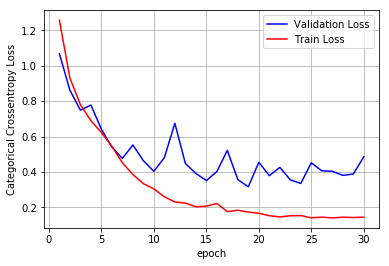

In [47]:
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

nb_epoch = 30
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs


vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

- We can see as we decreased the dropout rate to 0.3, the accuracy of the model increased to 92.16%  and loss decreased to 0.24.

In [48]:
# experiment 3- we add two lstm layers
n_hidden = 32
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden,return_sequences=True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
model.add(LSTM(n_hidden,))
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 128, 32)           5376      
_________________________________________________________________
dropout_5 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 198       
Total params: 13,894
Trainable params: 13,894
Non-trainable params: 0
_________________________________________________________________


In [49]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [50]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 166s 23ms/step - loss: 1.2349 - acc: 0.5000 - val_loss: 1.1344 - val_acc: 0.4842
Epoch 2/30
7352/7352 [==============================] - 168s 23ms/step - loss: 0.8493 - acc: 0.6085 - val_loss: 0.8358 - val_acc: 0.6023
Epoch 3/30
7352/7352 [==============================] - 164s 22ms/step - loss: 0.7219 - acc: 0.6591 - val_loss: 0.7699 - val_acc: 0.6447
Epoch 4/30
7352/7352 [==============================] - 165s 22ms/step - loss: 0.6277 - acc: 0.7289 - val_loss: 0.7184 - val_acc: 0.7350
Epoch 5/30
7352/7352 [==============================] - 164s 22ms/step - loss: 0.4972 - acc: 0.7907 - val_loss: 0.7390 - val_acc: 0.7540
Epoch 6/30
7352/7352 [==============================] - 165s 22ms/step - loss: 0.4464 - acc: 0.8062 - val_loss: 0.5878 - val_acc: 0.7706
Epoch 7/30
7352/7352 [==============================] - 162s 22ms/step - loss: 0.3990 - acc: 0.8403 - val_loss: 0.5310 - val_acc: 

In [51]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING        ...         WALKING_UPSTAIRS
True                              ...                         
LAYING                 509        ...                       28
SITTING                  6        ...                        2
STANDING                 0        ...                        0
WALKING                  0        ...                       46
WALKING_DOWNSTAIRS       0        ...                       11
WALKING_UPSTAIRS         0        ...                      468

[6 rows x 6 columns]


In [52]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 11s 4ms/step


In [53]:
score

[0.36606557368492926, 0.9002375296912114]

Test score: 0.36606557368492926
Test accuracy: 0.9002375296912114


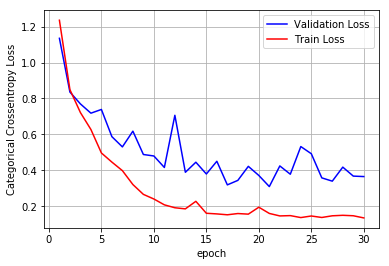

In [54]:
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

nb_epoch = 30
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs


vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [55]:
# experiment 3- we add two lstm layers
n_hidden = 32
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden,return_sequences=True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.7))
model.add(LSTM(n_hidden,))
model.add(Dropout(0.7))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 128, 32)           5376      
_________________________________________________________________
dropout_7 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 198       
Total params: 13,894
Trainable params: 13,894
Non-trainable params: 0
_________________________________________________________________


In [56]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [57]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 168s 23ms/step - loss: 1.3451 - acc: 0.4505 - val_loss: 1.1337 - val_acc: 0.4835
Epoch 2/30
7352/7352 [==============================] - 170s 23ms/step - loss: 1.0109 - acc: 0.5845 - val_loss: 0.8823 - val_acc: 0.5796
Epoch 3/30
7352/7352 [==============================] - 169s 23ms/step - loss: 0.8614 - acc: 0.6266 - val_loss: 0.7719 - val_acc: 0.6705
Epoch 4/30
7352/7352 [==============================] - 170s 23ms/step - loss: 0.7744 - acc: 0.6483 - val_loss: 0.7666 - val_acc: 0.6189
Epoch 5/30
7352/7352 [==============================] - 169s 23ms/step - loss: 0.7236 - acc: 0.6654 - val_loss: 0.7156 - val_acc: 0.6145
Epoch 6/30
7352/7352 [==============================] - 169s 23ms/step - loss: 0.6513 - acc: 0.6942 - val_loss: 0.6517 - val_acc: 0.7306
Epoch 7/30
7352/7352 [==============================] - 169s 23ms/step - loss: 0.5894 - acc: 0.7205 - val_loss: 0.7250 - val_acc: 

In [58]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING        ...         WALKING_UPSTAIRS
True                              ...                         
LAYING                 510        ...                       27
SITTING                  0        ...                       25
STANDING                 0        ...                       11
WALKING                  0        ...                       17
WALKING_DOWNSTAIRS       0        ...                        1
WALKING_UPSTAIRS         1        ...                      439

[6 rows x 6 columns]


In [59]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 11s 4ms/step


In [60]:
score

[0.6708572037886641, 0.8931116389548693]

Test score: 0.6708572037886641
Test accuracy: 0.8931116389548693


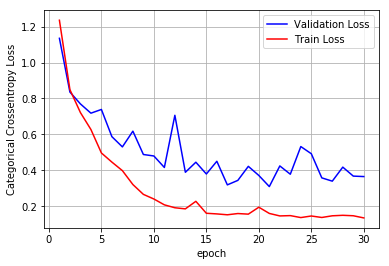

In [61]:
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

nb_epoch = 30
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs


vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [1]:
# Please compare all your models using Prettytable library

from prettytable import PrettyTable

x = PrettyTable()

x.field_names=['model','LSTM-layers','Drop-out','n-hidden','train-acc','test-acc']
x.add_row(['Model_1',1,0.5,32,94.83,90.09])
x.add_row(['Model_2',1,0.5,64,94.59,91.58])
x.add_row(['Model_3',1,0.8,32,76.26,74.62])
x.add_row(['Model_4',1,0.3,32,94.64,89.51])
x.add_row(['Model_5',2,0.5,32,95.17,90.02])
x.add_row(['Model_6',2,0.7,32,93.84,89.31])
 
print (x)

+---------+-------------+----------+----------+-----------+----------+
|  model  | LSTM-layers | Drop-out | n-hidden | train-acc | test-acc |
+---------+-------------+----------+----------+-----------+----------+
| Model_1 |      1      |   0.5    |    32    |   94.83   |  90.09   |
| Model_2 |      1      |   0.5    |    64    |   94.59   |  91.58   |
| Model_3 |      1      |   0.8    |    32    |   76.26   |  74.62   |
| Model_4 |      1      |   0.3    |    32    |   94.64   |  89.51   |
| Model_5 |      2      |   0.5    |    32    |   95.17   |  90.02   |
| Model_6 |      2      |   0.7    |    32    |   93.84   |  89.31   |
+---------+-------------+----------+----------+-----------+----------+
